Compiling model...
Building feed-forward neural network...
'build' took 0.030391 s

'compile' took 0.549936 s

Initializing variables...
Training model...

0         [3.22e-02, 2.28e-01]    [3.22e-02, 2.28e-01]    []  
0 [1.00e+00, 5.00e-03]
1000      [2.25e-02, 3.92e-02]    [2.25e-02, 3.92e-02]    []  
1000 [1.54e+00, -1.29e-02]
2000      [1.32e-02, 1.77e-02]    [1.32e-02, 1.77e-02]    []  
2000 [2.41e+00, -4.44e-03]
3000      [6.41e-03, 7.78e-03]    [6.41e-03, 7.78e-03]    []  
3000 [3.11e+00, -2.01e-03]
4000      [3.72e-03, 3.30e-03]    [3.72e-03, 3.30e-03]    []  
4000 [3.67e+00, -7.99e-04]
5000      [2.31e-03, 1.42e-03]    [2.31e-03, 1.42e-03]    []  
5000 [4.09e+00, -2.65e-04]
6000      [1.72e-03, 6.81e-04]    [1.72e-03, 6.81e-04]    []  
6000 [4.38e+00, -2.08e-05]
7000      [1.35e-03, 4.03e-04]    [1.35e-03, 4.03e-04]    []  
7000 [4.53e+00, 1.64e-04]
8000      [1.03e-03, 2.02e-04]    [1.03e-03, 2.02e-04]    []  
8000 [4.65e+00, 5.71e-04]
9000      [8.28e-04, 1.17e-04]    [8.28e

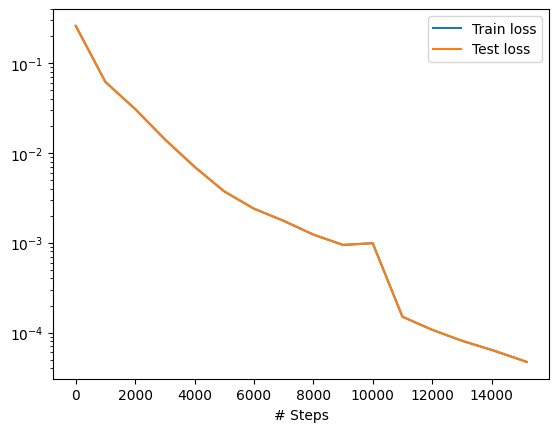

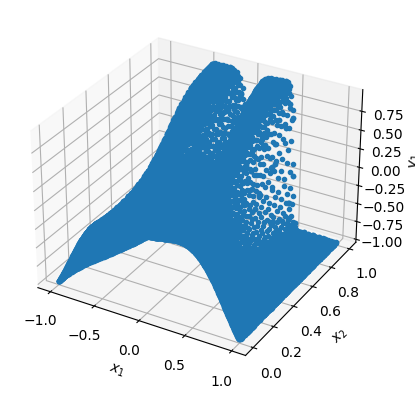

In [2]:
#to continue: solve the warnings, save trainable variables, tweak params
import deepxde as dde
import numpy as np
from scipy.io import loadmat
from deepxde.backend import tf

b = dde.Variable(1.0)
d = dde.Variable(0.005)
#d = tf.Variable(0.005)

def gen_data():
    data = loadmat("Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    dt = dx = 0.01
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = u.flatten()[:, None]
    return X, y

def gen_observations(X, y, num): #####################################################################################
    idx = np.random.choice(X.shape[0], num, replace=False)
    return X[idx, :], y[idx]

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - d * dy_xx - b * (y - y**3)

def output_transform(x, y):
    return x[:, 0:1]**2 * tf.cos(np.pi * x[:, 0:1]) + x[:, 1:2] * (1 - x[:, 0:1]**2) * y

X, y_true = gen_data()
x_observe, y_observe = gen_observations (X, y_true, 1000) ################################################################
observe_y = dde.icbc.PointSetBC(x_observe, y_observe, component=0)

data = dde.data.TimePDE(geomtime, 
                        pde, 
                        [observe_y], 
                        num_domain = 8000, 
                        num_boundary = 400, 
                        num_initial = 800,
                        anchors = x_observe,
                       )

net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
net.apply_output_transform(output_transform)
model = dde.Model(data, net)


variable = dde.callbacks.VariableValue([b, d], period=1000)

model.compile("adam", lr=1e-3, external_trainable_variables = [b,d])
model.train(iterations=10000, callbacks=[variable])

model.compile("L-BFGS", external_trainable_variables = [b,d])
losshistory, train_state = model.train(callbacks = [variable])

dde.saveplot(losshistory, train_state, issave=True, isplot=True)